In [1]:
import numpy as np
from scipy import sparse

class ReducedRankRegressor(object):
    """
    Reduced Rank Regressor (linear 'bottlenecking' or 'multitask learning')
    - X is an n-by-d matrix of features.
    - Y is an n-by-D matrix of targets.
    - rrank is a rank constraint.
    - reg is a regularization parameter (optional).
    """
    def __init__(self, X, Y, rank, reg=None):
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        if np.size(np.shape(Y)) == 1:
            Y = np.reshape(Y, (-1, 1))
        if reg is None:
            reg = 0
        self.rank = rank

        CXX = np.dot(X.T, X) + reg * sparse.eye(np.size(X, 1))
        CXY = np.dot(X.T, Y)
        _U, _S, V = np.linalg.svd(np.dot(CXY.T, np.dot(np.linalg.pinv(CXX), CXY)))
        self.W = V[0:rank, :].T
        self.A = np.dot(np.linalg.pinv(CXX), np.dot(CXY, self.W)).T

    def __str__(self):
        return 'Reduced Rank Regressor (rank = {})'.format(self.rank)

    def predict(self, X):
        """Predict Y from X."""
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        return np.dot(X, np.dot(self.A.T, self.W.T))

In [3]:
import os
import numpy as np
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import matplotlib.pyplot as plt

In [4]:
fname='/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/kay_images.npz'
with np.load(fname) as dobj:
    dat = dict(**dobj)

In [5]:
dat.keys()

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])

In [6]:
print(dat['roi_names'])

['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']


In [7]:
print(dat['responses'].shape)

(1750, 8428)


In [26]:
v1_rois=np.where(dat['roi']==1)
print(v1_rois)
v1_dat=dat['responses'][:,v1_rois].reshape(1750,-1)

(array([ 187,  199,  213, ..., 8281, 8331, 8355]),)


In [33]:
v2_rois=np.where(dat['roi']==2)
print(v2_rois)
v2_dat=dat['responses'][:,v2_rois].reshape(1750,-1)

(array([  26,   27,   29, ..., 8381, 8399, 8400]),)


In [28]:
rrr=ReducedRankRegressor(v1_dat,v2_dat,rank=5)

In [29]:
v1_test=dat['responses_test'][:,v1_rois].reshape(120,-1)
v2_test=dat['responses_test'][:,v2_rois].reshape(120,-1)

In [30]:
pred=rrr.predict(v1_test)

In [31]:
print(np.corrcoef(v2_test,pred))

[[ 1.00000000e+00  4.69067049e-01  5.93916349e-01 ... -1.46599717e-01
  -6.89914552e-03  1.06922176e-01]
 [ 4.69067049e-01  1.00000000e+00  5.45436767e-01 ... -1.21802726e-04
  -1.49919899e-01  1.73951125e-01]
 [ 5.93916349e-01  5.45436767e-01  1.00000000e+00 ... -1.24036985e-01
   4.54914758e-02  1.79086501e-02]
 ...
 [-1.46599717e-01 -1.21802726e-04 -1.24036985e-01 ...  1.00000000e+00
  -4.20180242e-02 -5.41616628e-02]
 [-6.89914552e-03 -1.49919899e-01  4.54914758e-02 ... -4.20180242e-02
   1.00000000e+00 -7.69504815e-01]
 [ 1.06922176e-01  1.73951125e-01  1.79086501e-02 ... -5.41616628e-02
  -7.69504815e-01  1.00000000e+00]]


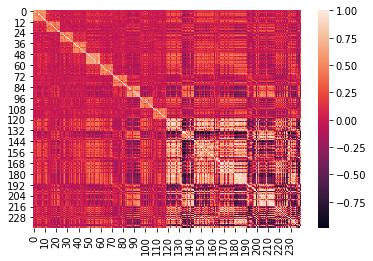

In [32]:
corr=np.corrcoef(v2_test,pred)
import seaborn as sns
sns.heatmap(corr)

In [34]:
ep=EnsemblePursuit(lam=0.01,n_components=100,n_kmeans=100)
ep.fit(dat['responses'])

obtained 100 PCs in 5.6839 seconds
initialized 100 clusters with k-means in 2.0784 seconds
ensemble 0, time 3.22, nr neurons 5040, EV 0.0630
ensemble 25, time 26.12, nr neurons 634, EV 0.1846
ensemble 50, time 41.30, nr neurons 369, EV 0.2195
ensemble 75, time 52.70, nr neurons 201, EV 0.2394
ensemble 99, time 63.00, nr neurons 142, EV 0.2544
average sparsity is 0.0678


In [37]:
U=ep.weights
ensemble=np.nonzero(U[:,0])[0]

In [ ]:
corr[corr>0.5]

In [41]:
n_ens=set(ensemble)
v1_overlap=n_ens.intersection(set(list(v1_rois[0].flatten())))

In [ ]:
print(v1_)